In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from keras.utils import np_utils
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
from mord import LogisticIT # mord库是专门做有序回归的包，包括有序逻辑回归、有序岭回归等
import warnings
warnings.filterwarnings("ignore")
# import joblib
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

使用已经清洗好、独热编码后的数据

In [2]:
df = pd.read_csv('data_0601_one_hot.csv')
y = df.pop('Severity')
xtrain, xtest, ytrain, ytest = train_test_split(df,y, test_size = 0.05,random_state = 0)
ytrue_p = np_utils.to_categorical(ytest- 1, 4)

# 单类预测

In [3]:
ypre = [2 for i in range(124805)]
print('准确率:',accuracy_score(ytest, ypre))
print(confusion_matrix(ytest, ypre))
ypre_p = np.asarray([[0,1,0,0] for _ in range(124805)])
print('AUC:', roc_auc_score(ytrue_p, ypre_p))

准确率: 0.6906694443331597
[[    0  3003     0     0]
 [    0 86199     0     0]
 [    0 29264     0     0]
 [    0  6339     0     0]]
AUC: 0.5


# 逻辑回归

In [4]:
md = LogisticRegression().fit(xtrain, ytrain)
ypre = md.predict(xtest)
print('准确率:',accuracy_score(ytest, ypre))
print(confusion_matrix(ytest, ypre))
ypre_p = md.predict_proba(xtest)
print('AUC:', roc_auc_score(ytrue_p, ypre_p))

准确率: 0.690533231841673
[[    0  3003     0     0]
 [    1 86178    12     8]
 [    7 29235     2    20]
 [    4  6329     4     2]]
AUC: 0.6346232641613931


# 有序逻辑回归

In [5]:
md = LogisticIT(max_iter = 1000, alpha = 0.1,verbose = 1).fit(xtrain, ytrain)
ypre = md.predict(xtest)
print('准确率:',accuracy_score(ytest, ypre))
print(confusion_matrix(ytest, ypre))
ypre_p = md.predict_proba(xtest)
print('AUC:', roc_auc_score(ytrue_p, ypre_p))

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
准确率: 0.6937702816393574
[[    0  3002     1     0]
 [    0 86185    14     0]
 [    0 28789   377    98]
 [    0  6275    40    24]]
AUC: 0.6117634001419867


# K近邻

In [6]:
md = KNeighborsClassifier(n_neighbors=5).fit(xtrain, ytrain)
ypre = md.predict(xtest)
print('准确率:',accuracy_score(ytest, ypre))
print(confusion_matrix(ytest, ypre))
ypre_p = md.predict_proba(xtest)
print('AUC:',roc_auc_score(ytrue_p, ypre_p))

准确率: 0.7184567925964505
[[  696  1801   490    16]
 [  589 78897  6197   516]
 [  457 19072  9453   282]
 [   76  4640  1002   621]]
AUC: 0.7371565968740933


# 决策树

In [7]:
md = DecisionTreeClassifier().fit(xtrain, ytrain) # 调参后发现最优即为默认参数，详见验证集调优
ypre = md.predict(xtest)
print(confusion_matrix(ytest, ypre))
ypre_p = md.predict_proba(xtest)
print('准确率:',accuracy_score(ytest, ypre))
print('AUC:',roc_auc_score(ytrue_p, ypre_p))

[[ 1242  1137   540    84]
 [ 1165 75800  7333  1901]
 [  702 11630 15578  1354]
 [  102  3180  1149  1908]]
准确率: 0.7574055526621529
AUC: 0.7174831665912089


# 随机森林

In [8]:
md = RandomForestClassifier(n_estimators=50).fit(xtrain, ytrain)
ypre = md.predict(xtest)
ypre_p = md.predict_proba(xtest)
print('准确率:',accuracy_score(ytest, ypre),'AUC:',roc_auc_score(ytrue_p, ypre_p))
print(confusion_matrix(ytest, ypre))

准确率: 0.7809222386923601 AUC: 0.8514412308226225
[[ 1020  1523   449    11]
 [  404 80848  3871  1076]
 [  212 14854 13907   291]
 [   33  3703   915  1688]]


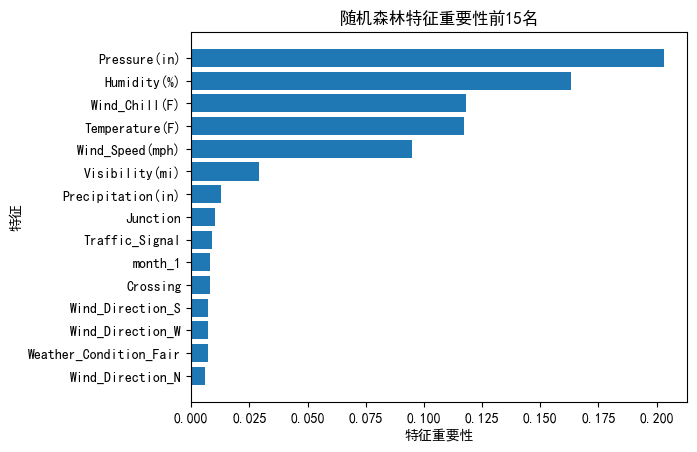

In [9]:
# 特征影响力
importance = md.feature_importances_.tolist()
column_name = xtrain.columns.values.tolist() # 训练集上获取各个列的列名
column_order = list()
importance_order = list()
clip = 13
for i in range(len(importance)):
    index = importance.index(max(importance))
    column_order_temp = column_name[index]
    importance_order_temp = round(importance[index], 3)
    column_order.append(column_order_temp)
    importance_order.append(importance_order_temp)
    # print(column_order_temp + ':' +  str(importance_order_temp))
    column_name.pop(index)
    importance.pop(index)
    if i > clip:
        break

# 画出特征影响力的柱状图
a = plt.barh(column_order[::-1], importance_order[::-1], align='center')
plt.xlabel('特征重要性')
plt.ylabel('特征')
plt.title(f'随机森林特征重要性前{clip + 2}名')
plt.show()

# LightGBM

In [2]:
df2 = pd.read_csv('data_0601.csv') # 重新读入一份非独热编码的数据
df2.pop('index') # 去掉索引列
category_cns = ['Wind_Direction','Weather_Condition','Sunrise_Sunset'
            ,'Civil_Twilight','Nautical_Twilight','Astronomical_Twilight','month']
for cn in category_cns:
    df2[cn] = df2[cn].astype('category') # lightgbm处理类别特征无需独热编码
y = df2.pop('Severity')
xtrain, xtest, ytrain, ytest = train_test_split(df2,y, test_size = 0.05,random_state = 0)
ytrue_p = np_utils.to_categorical(ytest- 1, 4)
fit_params = {
    "early_stopping_rounds":30,
    "eval_metric":'auc_mu',
    "eval_set":[(xtest,ytest)],
    "eval_names":['valid'],
    'verbose':100,
    'feature_name':'auto',
    'categorical_feature':'auto'
}
md = LGBMClassifier(num_leaves = 15
                       ,max_depth = -1
                       ,silent = True
                       ,metric = 'None'
                       ,n_jobs = 4
                       , n_estimators = 1000
                       ,colsample_bytree = 0.9
                       ,subsample = 0.9
                       ,learning_rate = 0.1
                      )
md.fit(xtrain,ytrain,**fit_params)
ypre = md.predict(xtest)
print('准确率:',accuracy_score(ytest, ypre))
print(confusion_matrix(ytest, ypre))
ypre_p = md.predict_proba(xtest)
print('AUC:',roc_auc_score(ytrue_p, ypre_p))

[100]	valid's auc_mu: 0.796185
[200]	valid's auc_mu: 0.803538
[300]	valid's auc_mu: 0.80759
[400]	valid's auc_mu: 0.810173
[500]	valid's auc_mu: 0.812697
[600]	valid's auc_mu: 0.814528
[700]	valid's auc_mu: 0.81628
[800]	valid's auc_mu: 0.817532
[900]	valid's auc_mu: 0.818553
[1000]	valid's auc_mu: 0.819532
准确率: 0.7224710548455591
[[  411  2334   258     0]
 [  154 83930  2110     5]
 [   92 23402  5756    14]
 [   32  5585   651    71]]
AUC: 0.7737760881409608
